In [31]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(modelr)
library(rsample)
library(mosaic)
library(tidymodels)
library(pROC)
library(glmnet)
library(caret)
data(SaratogaHouses)

In [11]:
print("Problem 1:Saratoga house prices")
options( warn = - 1)

[1] "Problem 1:Saratoga house prices"


In [ ]:
glimpse(SaratogaHouses)

In [13]:
# Split into training and testing sets
saratoga_split = initial_split(SaratogaHouses, prop = 0.8)
saratoga_train = training(saratoga_split)
saratoga_test = testing(saratoga_split)

In [ ]:
lm1 = lm(price ~ lotSize + bedrooms + bathrooms, data=saratoga_train)
lm2 = lm(price ~ . - pctCollege - sewer - waterfront - landValue - newConstruction, data=saratoga_train)
lm3 = lm(price ~ (. - pctCollege - sewer - waterfront - landValue - newConstruction)^2, data=saratoga_train)

coef(lm1) %>% round(0)
coef(lm2) %>% round(0)
coef(lm3) %>% round(0)

In [17]:
# Predictions out of sample
# Root mean squared error
lm_rmse1 = modelr::rmse(lm1, saratoga_test)
lm_rmse2 = modelr::rmse(lm2, saratoga_test)
lm_rmse3 = modelr::rmse(lm3, saratoga_test)

print("Before fitting the best linear model, I run some simply model aiming to find the alternative RMSE number. There are three simply models: lm1, with lotSize, bedrooms and bathrooms as features.")
print("lm2, without pctCollege, sewer, waterfront, landValue and newConstruction. And lm3, without features afore-mentioned and square the rest features. Their RMSE are displayed following.") 
print("From the result, we drop lm1 model.")
print("RMSE")
print(paste("linear model with three features lotSize, bedrooms and bathrooms:", lm_rmse1))
print(paste("linear model exclude pctCollege, sewer, waterfront, landValue, newConstruction:", lm_rmse2))
print(paste("linear model exclude pctCollege, sewer, waterfront, landValue, newConstructionand squared:", lm_rmse3))


[1] "Before fitting the best linear model, I run some simply model aiming to find the alternative RMSE number. There are three simply models: lm1, with lotSize, bedrooms and bathrooms as features."
[1] "lm2, without pctCollege, sewer, waterfront, landValue and newConstruction. And lm3, without features afore-mentioned and square the rest features. Their RMSE are displayed following."
[1] "From the result, we drop lm1 model."
[1] "RMSE"
[1] "linear model with three features lotSize, bedrooms and bathrooms: 81946.900195026"
[1] "linear model exclude pctCollege, sewer, waterfront, landValue, newConstruction: 71494.2424168182"
[1] "linear model exclude pctCollege, sewer, waterfront, landValue, newConstructionand squared: 71501.6631795597"


In [19]:
out = do(100)*{
  saratoga_split = initial_split(SaratogaHouses, prop = 0.8)
  saratoga_train = training(saratoga_split)
  saratoga_test = testing(saratoga_split)
  lm2 = lm(price ~ (. - pctCollege - sewer - waterfront - landValue -
                 newConstruction), data=saratoga_train)
  lm3 = lm(price ~ (. - pctCollege - sewer - waterfront - landValue -
                      newConstruction)^2, data=saratoga_train)
  rmse2 = modelr::rmse(lm2, saratoga_test)
  rmse3 = modelr::rmse(lm3, saratoga_test)
  c(rmse2, rmse3)
}

print("In order to address random variation due to the particular choice of data points that end up in train/test split, I loop the split process 100 times. ")
print("From the result, we drop lm3.")
print(paste("Average RMSE of model 2 for 100 times split:", colMeans(out)[1]))
print(paste("Average RMSE of model 3 for 100 times split:", colMeans(out)[2]))

[1] "In order to address random variation due to the particular choice of data points that end up in train/test split, I loop the split process 100 times. "
[1] "Average RMSE of model 2 for 100 times split: 66652.2281946853"
[1] "Average RMSE of model 3 for 100 times split: 71729.2865820363"


In [21]:
print("Then we build the medium model and see what features are the most important.")
print("As we can see from the list of model feature significance, livingArea, bedrooms, bathrooms and centralAirNo are the most significant.")
# baseline medium model with 11 main effects
lm_medium = lm(price ~ lotSize + age + livingArea + pctCollege + bedrooms + 
		fireplaces + bathrooms + rooms + heating + fuel + centralAir, data=saratoga_train)


summary(lm_medium)


[1] "Then we build the medium model and see what features are the most important."
[1] "As we can see from the list of model feature significance, livingArea, bedrooms, bathrooms and centralAirNo are the most significant."



Call:
lm(formula = price ~ lotSize + age + livingArea + pctCollege + 
    bedrooms + fireplaces + bathrooms + rooms + heating + fuel + 
    centralAir, data = saratoga_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-239141  -38863   -7801   28286  460293 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             37745.253  13739.500   2.747  0.00609 ** 
lotSize                  9186.016   2811.317   3.268  0.00111 ** 
age                       -51.253     73.609  -0.696  0.48637    
livingArea                 93.889      5.543  16.938  < 2e-16 ***
pctCollege                148.654    184.810   0.804  0.42133    
bedrooms               -15240.778   3179.247  -4.794 1.81e-06 ***
fireplaces               3482.148   3803.719   0.915  0.36011    
bathrooms               19359.116   4227.426   4.579 5.09e-06 ***
rooms                    3388.158   1224.644   2.767  0.00574 ** 
heatinghot water/steam  -9887.213   5274.098  -1.875  0

In [23]:
out = do(100)*{
  saratoga_split = initial_split(SaratogaHouses, prop = 0.8)
  saratoga_train = training(saratoga_split)
  saratoga_test = testing(saratoga_split)
  lm_medium = lm(price ~ lotSize + age + livingArea + pctCollege + bedrooms + 
		fireplaces + bathrooms + rooms + heating + fuel + centralAir, data=saratoga_train)
  rmse_m = modelr::rmse(lm_medium, saratoga_test)
  c(rmse_m)
}

print("Same method to address the random variation. 100 times split.")
print(paste("Average RMSE of medium model:", colMeans(out)))

[1] "Same method to address the random variation. 100 times split."
[1] "Average RMSE of medium model: 67004.8123990562"


In [45]:
# Perform stepwise selection
lm_step <- stats::step(lm_medium, 
                scope = list(lower = formula(lm_medium), upper = formula(~(.)^2)), 
                direction = "both", # Stepwise both forward and backward
                trace = 0) # Set trace = 1 for more detailed output


out = do(100)*{
  saratoga_split = initial_split(SaratogaHouses, prop = 0.8)
  saratoga_train = training(saratoga_split)
  saratoga_test = testing(saratoga_split)
  lm_step = stats::step(lm_medium, 
                scope = list(lower = formula(lm_medium), upper = formula(~(.)^2)), 
                direction = "both", # Stepwise both forward and backward
                trace = 0)
  rmse_s = modelr::rmse(lm_step, saratoga_test)
  c(rmse_s)
}

print("Now we are using step function to build the best model. As listed below, the RMSE is great.")
print(paste("Then display steps model's RMSE for 100 times split:", colMeans(out)))
summary(lm_step)

[1] "Now we are using step function to build the best model. As listed below, the RMSE is great."
[1] "Then display steps model's RMSE for 100 times split: 63606.2788864052"



Call:
lm(formula = price ~ lotSize + age + livingArea + pctCollege + 
    bedrooms + fireplaces + bathrooms + rooms + heating + fuel + 
    centralAir + livingArea:centralAir + bathrooms:heating + 
    age:pctCollege + lotSize:age + pctCollege:fireplaces + pctCollege:bathrooms + 
    bedrooms:fireplaces + livingArea:fireplaces + age:centralAir + 
    fireplaces:centralAir + pctCollege:fuel + livingArea:fuel + 
    age:fuel + age:bathrooms + lotSize:fireplaces + lotSize:pctCollege, 
    data = saratoga_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-285110  -35120   -4903   28585  502947 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       46557.093  41024.171   1.135 0.256632    
lotSize                           -4998.848  13952.080  -0.358 0.720185    
age                               -2294.666    463.231  -4.954 8.21e-07 ***
livingArea                           80.402      8.852   9.083  < 2e-16 

In [60]:
# For demonstration purposes, let's consider a subset of features
saratoga_subset <- SaratogaHouses %>%
  select(price, lotSize, bedrooms, bathrooms, rooms, heating, fuel, age, livingArea, pctCollege, centralAir, fireplaces) %>%
  mutate(
    # Example: Create interaction terms
    lot_bed_interaction = lotSize * bedrooms,
    # Example: Create polynomial terms
    lotSize_squared = lotSize^2
  )


# Split scaled data
set.seed(123) # for reproducibility
saratoga_scaled_split <- initial_split(saratoga_subset, prop = 0.8)
saratoga_scaled_train <- training(saratoga_scaled_split)
saratoga_scaled_test <- testing(saratoga_scaled_split)

# Build KNN regression model
knn_model <- train(
  price ~ .,
  data = saratoga_scaled_train,
  method = "knn",
  trControl = trainControl(method = "cv", number = 5), # 5-fold cross-validation
  preProcess = c("center", "scale") # Standardize variables
)


print("Now sart the KNN model.")
print("From the lm part we find the significance of features, thus we would use them in KNN.")
print("As listed, the RMSE of KNN is bigger than lm model. Which means lm model seems do better at achieving lower out-of-sample mean-squared error.")

# Print model summary
print(knn_model)

# Predict on test set
knn_predictions <- predict(knn_model, newdata = saratoga_scaled_test)

# Calculate MSE
knn_mse <- mean((saratoga_test$price - knn_predictions)^2)


[1] "Now sart the KNN model."
[1] "From the lm part we find the significance of features, thus we would use them in KNN."
[1] "As listed, the RMSE of KNN is bigger than lm model. Which means lm model seems do better at achieving lower out-of-sample mean-squared error."
k-Nearest Neighbors 

1382 samples
  13 predictor

Pre-processing: centered (15), scaled (15) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1106, 1106, 1104, 1105, 1107 
Resampling results across tuning parameters:

  k  RMSE      Rsquared   MAE     
  5  69794.09  0.5267745  48649.34
  7  68650.50  0.5419270  47480.44
  9  68304.26  0.5483475  47480.69

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 9.


In [61]:
print("Problem 2:Classification and retrospective sampling")

[1] "Problem 2:Classification and retrospective sampling"


In [62]:
library(ggplot2)
library(caTools)  # For sample.split function
library(caret)     # For confusionMatrix function

[1] "As the bar plot displays, higher credit history is supposed to have lower possibility to default."
[1] "That makes sense in a kind of way for good credit history represents better financial situation in the past."


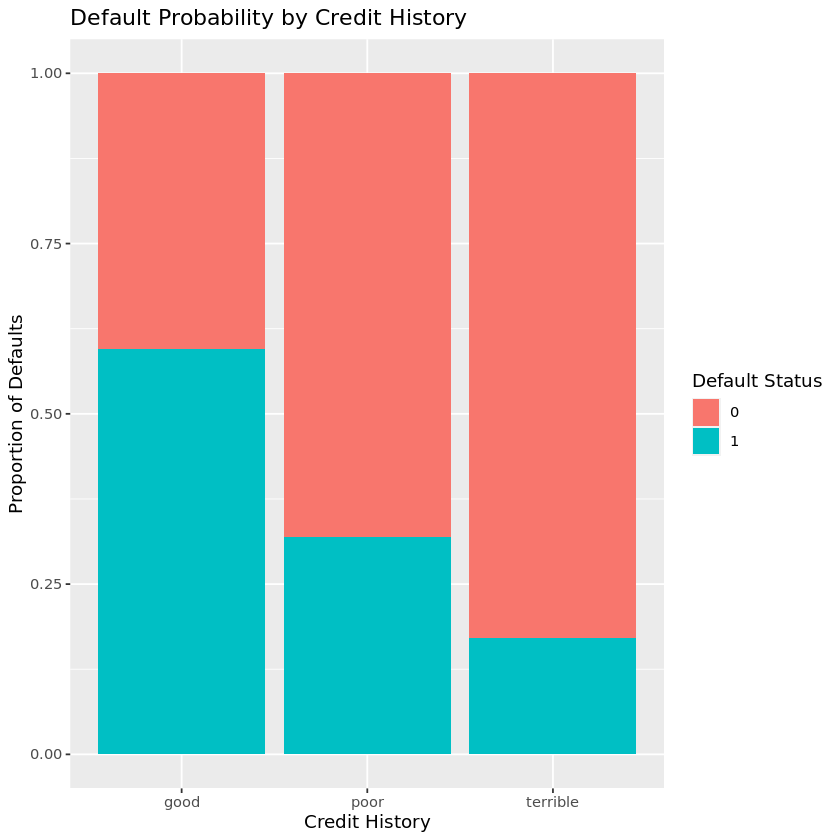

In [65]:
# Load the data
german_credit <- read.csv("data/german_credit.csv")

# Create a bar plot
ggplot(german_credit, aes(x = history, fill = factor(Default))) +
  geom_bar(position = "fill") +
  labs(x = "Credit History", y = "Proportion of Defaults", fill = "Default Status") +
  ggtitle("Default Probability by Credit History")

print("As the bar plot displays, higher credit history is supposed to have lower possibility to default.")
print("That makes sense in a kind of way for good credit history represents better financial situation in the past.")

In [67]:
# Split the data into train and test sets (80-20 split)
set.seed(123) 

# Initialize vector to store correct rates
correct_rates <- numeric(100)

split <- sample.split(german_credit$Default, SplitRatio = 0.8)
train_data <- subset(german_credit, split == TRUE)
test_data <- subset(german_credit, split == FALSE)
  
logit_model <- glm(Default ~ duration + amount + installment + age + history + purpose + foreign,
                   data = train_data,
                   family = binomial)

summary(logit_model)

for (i in 1:100) {
  split <- sample.split(german_credit$Default, SplitRatio = 0.8)
  train_data <- subset(german_credit, split == TRUE)
  test_data <- subset(german_credit, split == FALSE)
  
  logit_model <- glm(Default ~ duration + amount + installment + age + history + purpose + foreign,
                   data = train_data,
                   family = binomial)
  
  predicted <- predict(logit_model, newdata = test_data, type = "response")
  predicted_class <- ifelse(predicted > 0.5, 1, 0)

  correct_rate <- mean(predicted_class == test_data$Default)
  
  # Store correct rate for this iteration
  correct_rates[i] <- correct_rate
  c(correct_rates)
  }

# Summary of correct rates
mean_correct_rate <- mean(correct_rates)

# Display correct rate
print(paste("After building model on 100 times split, the correct rate (Mean), given features duration + amount + installment + age + history + purpose + foreign:", round(mean_correct_rate * 100, 2), "%"))
print(paste("As we can see, history is important in default prediction but the dataset is not big enough to permit the model to forecast future default given average correct rate.", round(mean_correct_rate * 100, 2), "%"))
print("First, the dataset could be small to build a suitable model to screen prospective borrowers to classify them into 'high' versus 'low' probability of default.")
print("Second, credit history is the symbol of past. We could see that the accuracy is not high enough to be safe for the bank.")
print("I would recommend add the change of account statement in a period and calculate the fluctuation as one feature. And expand the dataset.")



Call:
glm(formula = Default ~ duration + amount + installment + age + 
    history + purpose + foreign, family = binomial, data = train_data)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -7.575e-01  5.365e-01  -1.412 0.157974    
duration             2.808e-02  9.060e-03   3.099 0.001941 ** 
amount               9.081e-05  4.255e-05   2.134 0.032810 *  
installment          2.145e-01  8.475e-02   2.532 0.011356 *  
age                 -1.263e-02  8.124e-03  -1.555 0.120009    
historypoor         -1.060e+00  2.863e-01  -3.703 0.000213 ***
historyterrible     -1.828e+00  3.205e-01  -5.704 1.17e-08 ***
purposeedu           3.444e-01  4.132e-01   0.834 0.404470    
purposegoods/repair -1.219e-01  2.807e-01  -0.434 0.664173    
purposenewcar        4.337e-01  3.088e-01   1.405 0.160087    
purposeusedcar      -1.109e+00  3.943e-01  -2.813 0.004916 ** 
foreigngerman       -1.111e+00  6.857e-01  -1.621 0.105086    
---
Signif. codes:  0 ‘

[1] "After building model on 100 times split, the correct rate (Mean), given features duration + amount + installment + age + history + purpose + foreign: 72.26 %"
[1] "As we can see, history is important in default prediction but the dataset is not big enough to permit the model to forecast future default given average correct rate. 72.26 %"
[1] "First, the dataset could be small to build a suitable model to screen prospective borrowers to classify them into 'high' versus 'low' probability of default."
[1] "Second, credit history is the symbol of past. We could see that the accuracy is not high enough to be safe for the bank."
[1] "I would recommend add the change of account statement in a period and calculate the fluctuation as one feature. And expand the dataset."


In [68]:
print("Problem 3:Children and hotel reservations")

[1] "Problem 3:Children and hotel reservations"


In [72]:
hotels_dev <- read.csv("data/hotels_dev.csv")

In [73]:
# Baseline 1: Small model
baseline_1 <- glm(children ~ market_segment + adults + customer_type + is_repeated_guest, 
                  data = hotels_dev, 
                  family = binomial)

In [74]:
# Baseline 2: Big model
baseline_2 <- glm(children ~ . - arrival_date, 
                  data = hotels_dev, 
                  family = binomial)
                 

In [75]:
# Best linear model
best_model <- glm(children ~ ., 
                  data = hotels_dev, 
                  family = binomial)
                  

In [78]:
print("Model building")

[1] "Model building"


In [79]:
print("I have built three models based on the samll model and big model, and use all features to buld the best model.")
print("Their out-of-sample performance are measured below.")

# Make predictions for baseline 1
pred_baseline_1 <- predict(baseline_1, type = "response")

# Make predictions for baseline 2
pred_baseline_2 <- predict(baseline_2, type = "response")

# Make predictions for the best model
pred_best_model <- predict(best_model, type = "response")

# Compute AUC-ROC for baseline 1
roc_baseline_1 <- roc(hotels_dev$children, pred_baseline_1)

# Compute AUC-ROC for baseline 2
roc_baseline_2 <- roc(hotels_dev$children, pred_baseline_2)

# Compute AUC-ROC for the best model
roc_best_model <- roc(hotels_dev$children, pred_best_model)


[1] "I have built three models based on the samll model and big model, and use all features to buld the best model."
[1] "Their out-of-sample performance are measured below."


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



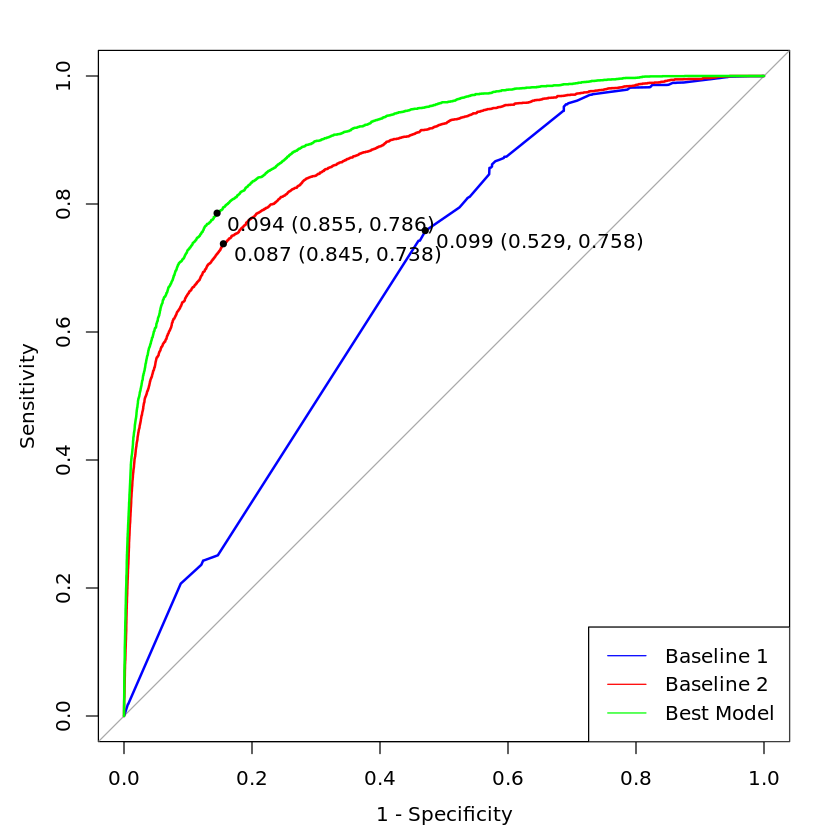

In [15]:
# Plot ROC curves
plot(roc_baseline_1, col = "blue", legacy.axes = TRUE, print.thres = TRUE)
plot(roc_baseline_2, col = "red", add = TRUE, print.thres = TRUE)
plot(roc_best_model, col = "green", add = TRUE, print.thres = TRUE)
legend("bottomright", legend = c("Baseline 1", "Baseline 2", "Best Model"), 
       col = c("blue", "red", "green"), lty = 1)
       

In [83]:
# Load hotels_val dataset
hotels_val <- read.csv("data/hotels_val.csv")

print("Model validation: step 1")


[1] "Model validation: step 1"


In [84]:
# Make predictions for the best model on hotels_val
pred_val <- predict(best_model, newdata = hotels_val, type = "response")
# Compute ROC curve for hotels_val
roc_val <- roc(hotels_val$children, pred_val)


Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [80]:
print("Following is the ROC curve of the best model on hotels_dev dataset.")

[1] "Following is the ROC curve of the best model on hotels_dev dataset."


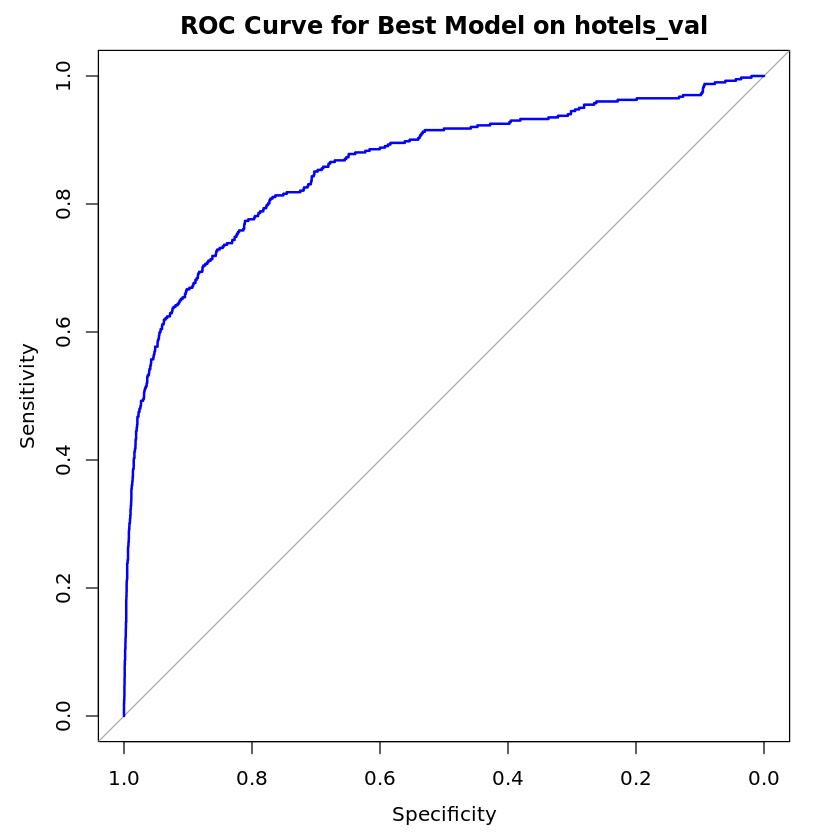

In [22]:
plot(roc_val, col = "blue", main = "ROC Curve for Best Model on hotels_val")

In [85]:
# Create 20 folds of hotels_val
folds <- createFolds(hotels_val$children, k = 20)
# Initialize vector to store performance metrics
performance <- numeric(length(folds))


In [86]:
# Perform cross-validation
for (i in 1:length(folds)) {
  # Get the indices of the current fold
  fold_indices <- folds[[i]]
  
  # Subset data for the current fold
  fold_data <- hotels_val[fold_indices, ]
  
  # Make predictions for the fold using the best model (step_model or any other)
  pred_fold <- predict(best_model, newdata = fold_data, type = "response")
  
  # Sum up the predicted probabilities for all bookings in the fold
  expected_children <- sum(pred_fold)
  
  # Actual number of bookings with children in the fold
  actual_children <- sum(fold_data$children)
  
  # Calculate the difference between expected and actual
  performance[i] <- abs(expected_children - actual_children)
}


In [102]:
summary(performance)
# Summarize the performance across all folds
mean_performance <- mean(performance)

# Print the mean performance
print(paste("Mean Performance across 20 folds:", mean_performance))
print("The mean performance is calculated by the average of amount (expected children minus actual children). I think it performs well at sometime but with huge variance.")

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.009318 1.291732 2.267023 2.918241 4.011663 8.912758 

[1] "Mean Performance across 20 folds: 2.91824051389483"
[1] "The mean performance is calculated by the average of amount (expected children minus actual children). I think it performs well at sometime but with huge variance."


In [3]:
print("Problem 4:Mushroom classification")

[1] "Problem 4:Mushroom classification"


In [91]:
# Load the mushroom dataset
mushrooms <- read.csv("data/mushrooms.csv", header = TRUE)


In [92]:
# Remove the stalk-root variable
mushrooms_clean <- mushrooms[, !grepl("^veil.type$", colnames(mushrooms))]
mushrooms_clean$class <- as.character(mushrooms_clean$class)
# Assuming 'mushrooms_transformed' is your dataset after transformation
mushrooms_clean$class <- ifelse(mushrooms_clean$class == "p", 1, 0)

mushrooms_dummies <- model.matrix(~ . - 1, data = mushrooms_clean)

In [93]:
# Split the data into predictors and target variable
X <- as.matrix(mushrooms_dummies[, -1])  # Predictor variables
y <- mushrooms_clean$class             # Target 

In [94]:
# Split the data into training and testing sets
set.seed(123)  # For reproducibility
train_index <- sample(1:nrow(X), 0.8 * nrow(X))  # 80% train, 20% test
X_train <- X[train_index, ]
X_test <- X[-train_index, ]
y_train <- y[train_index]
y_test <- y[-train_index]


Call:  cv.glmnet(x = X_train, y = y_train, nfolds = num_folds, family = "binomial",      alpha = 1) 

Measure: Binomial Deviance 

       Lambda Index  Measure       SE Nonzero
min 0.0001443    86 0.003990 0.002615      31
1se 0.0004838    73 0.006484 0.002173      29


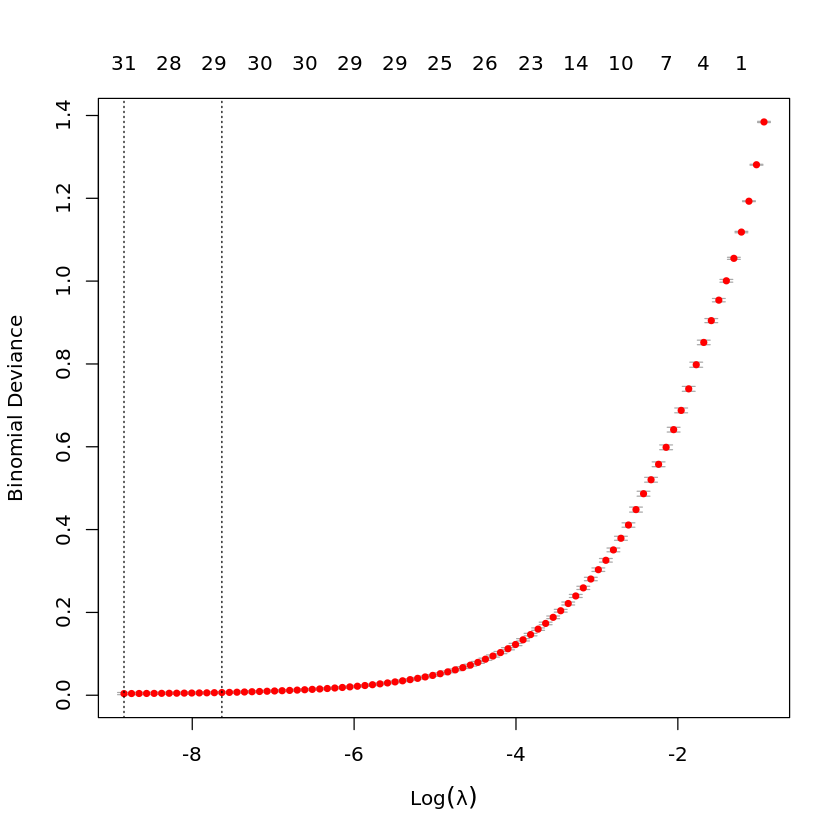

In [95]:
num_folds <- 10  # Adjust this number as needed
# Fit the Lasso logistic regression model
lasso_model <- cv.glmnet(X_train, y_train, family = "binomial", alpha = 1,nfolds = num_folds)

# Plot the cross-validated mean deviance against log(lambda)
plot(lasso_model)

print(lasso_model)


In [96]:
# Get the optimal lambda value
best_lambda <- lasso_model$lambda.min
# Make predictions on the testing set
predictions <- predict(lasso_model, s = best_lambda, newx = X_test, type = "response")


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Optimal Probability Threshold: 0.316784641985971"
[1] "With lasso model I find that under optimal threshold 0.316784641985971, the model performs quite perfect. Thus I can't rejct the hypothesis that the model is overfitted even for the test dataset."


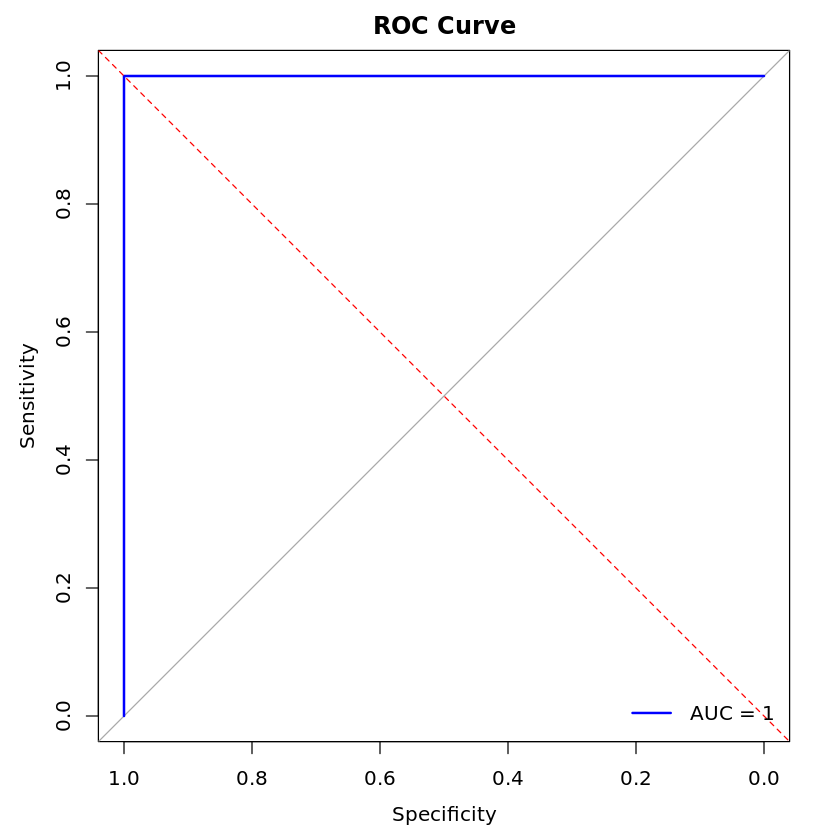

In [99]:
roc_curve <- roc(y_test, predictions)
auc_score <- auc(roc_curve)

# Plot ROC curve
plot(roc_curve, main = "ROC Curve", col = "blue", lwd = 2)
abline(a = 0, b = 1, lty = 2, col = "red")
legend("bottomright", legend = paste("AUC =", round(auc_score, 2)), col = "blue", lwd = 2, bty = "n")

# Determine optimal probability threshold
optimal_threshold <- coords(roc_curve, "best", best.method = "closest.topleft")
# Print optimal threshold
print(paste("Optimal Probability Threshold:", optimal_threshold$threshold))
print("With lasso model I find that under optimal threshold 0.316784641985971, the model performs quite perfect. Thus I can't rejct the hypothesis that the model is overfitted even for the test dataset.")

In [26]:
# Convert probabilities to class labels based on a threshold
threshold <- 0.316784641985971
predicted_labels <- ifelse(predictions >= threshold, 1, 0)

# Compute accuracy
accuracy <- mean(predicted_labels == y_test)

# Print the accuracy
print(paste("Accuracy:", accuracy))

print("Also I calculate the accuracy of forecast in test model. That's 100 percent which fits to the ROC curve.")

[1] "Accuracy: 1"
